In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
customers = pd.read_csv('datasets/Customers.csv')
print("Shape of customers dataframe: ", customers.shape)
customers.head() 
#there are 4 different regions: 'South America', 'Asia', 'North America', 'Europe'


Shape of customers dataframe:  (200, 4)


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [3]:
products = pd.read_csv('datasets/Products.csv')
print("shape of products dataframe: ", products.shape)
products.head() ##there are 100 instances 
#there are 66 different products
#4 category: 'Books', 'Electronics', 'Home Decor', 'Clothing'

shape of products dataframe:  (100, 4)


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [4]:
transactions = pd.read_csv('datasets/Transactions.csv')
print("Shape of transactions dataframe: ", transactions.shape)
transactions.head() #this paticular dataframe is the intersection of customers and products

Shape of transactions dataframe:  (1000, 7)


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [60]:
merged_df = transactions.merge(customers, on='CustomerID', how='left')
merged_df = merged_df.merge(products, on='ProductID', how='left')

In [6]:
merged_df.drop(['Price_x', 'Price_y'], inplace=True, axis=1)

In [7]:
merged_df.head() #this has combined information

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,CustomerName,Region,SignupDate,ProductName,Category
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics


1. Sales vs Region spread over
2. Quantity vs Category vs Revenue

In [25]:
region_revenue = merged_df.groupby('Region')['TotalValue'].sum().reset_index()
region_revenue

,Region,TotalValue
0,Asia,152074.97
1,Europe,166254.63
2,North America,152313.40
3,South America,219352.56



1. South America leads with 31.61% of the total sales revenue, followed by Europe at 23.96%, while North America and Asia contribute similarly with 21.96% and 21.94%, respectively, highlighting South America's larger contribution.

C:\Users\mahes\AppData\Local\Temp\ipykernel_16440\1531860750.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




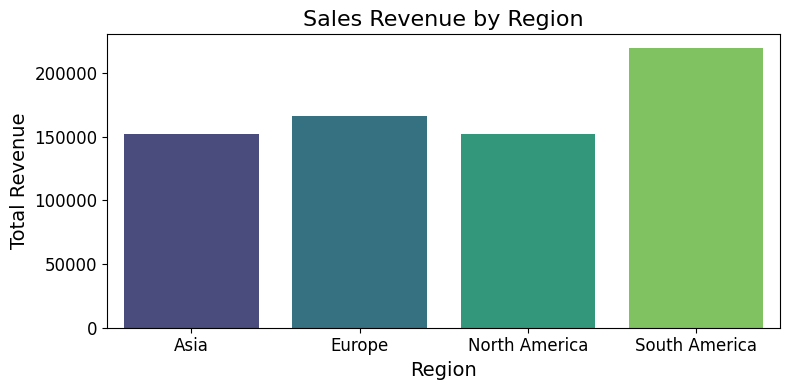

In [24]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Region', y='TotalValue', data=region_revenue, palette='viridis')
plt.title('Sales Revenue by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


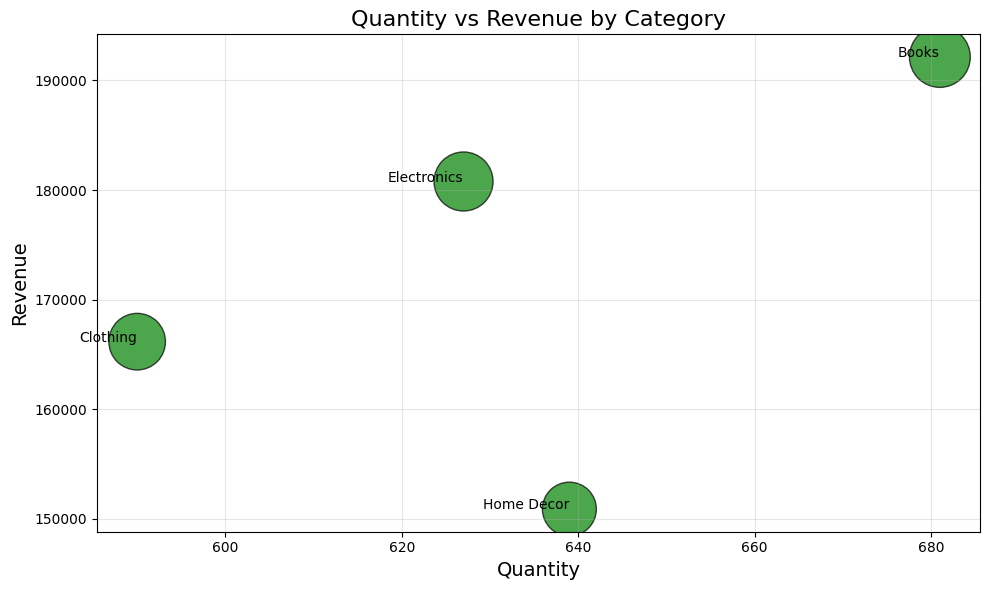

In [30]:
# Aggregating data for Quantity, Category, and Revenue
category_quantity_revenue = merged_df.groupby('Category').agg({'Quantity': 'sum', 'TotalValue': 'sum'}).reset_index()
# Using a scatter plot for better visualization of the relationship between Quantity and Revenue
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with quantity on x-axis and revenue on y-axis
scatter = ax.scatter(
    category_quantity_revenue['Quantity'],
    category_quantity_revenue['TotalValue'],
    s=category_quantity_revenue['TotalValue'] / 100,  # Scale point size by revenue
    c='green',
    alpha=0.7,
    edgecolors='black'
)

# Adding labels and title
for i, category in enumerate(category_quantity_revenue['Category']):
    ax.text(
        category_quantity_revenue['Quantity'][i],
        category_quantity_revenue['TotalValue'][i],
        category,
        fontsize=10,
        ha='right'
    )

ax.set_title('Quantity vs Revenue by Category', fontsize=16)
ax.set_xlabel('Quantity', fontsize=14)
ax.set_ylabel('Revenue', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [57]:
transactions = transactions.merge(customers, on='CustomerID', how='left')
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName_x,Region_x,SignupDate_x,CustomerName_y,Region_y,SignupDate_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,Timothy Perez,Europe,2022-03-15


In [50]:


# Convert dates to datetime
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['SignupDate'] = pd.to_datetime(transactions['SignupDate'])

# Function to calculate time difference for a specific CustomerID
def calculate_time_difference(customer_id):
    customer_data = transactions[transactions['CustomerID'] == customer_id]
    if not customer_data.empty:
        signup_date = customer_data['SignupDate'].iloc[0]
        first_transaction_date = customer_data['TransactionDate'].min()
        time_difference = first_transaction_date - signup_date
        if int(time_difference.days) < 0:
            print('negative time difference ', customer_id, first_transaction_date, signup_date)
            return -1
        return int(time_difference.days)
    else:
        return -1



ls = []
for c in customers['CustomerID']:
    ls.append(calculate_time_difference(c))


negative time difference  C0003 2024-02-18 02:50:37 2024-03-07 00:00:00
negative time difference  C0012 2024-05-12 12:53:40 2024-08-07 00:00:00
negative time difference  C0013 2024-02-24 20:08:07 2024-05-19 00:00:00
negative time difference  C0014 2024-01-17 18:31:55 2024-06-22 00:00:00
negative time difference  C0018 2024-02-17 18:50:52 2024-09-21 00:00:00
negative time difference  C0020 2024-01-30 00:57:29 2024-06-11 00:00:00
negative time difference  C0026 2024-03-20 10:30:55 2024-05-03 00:00:00
negative time difference  C0028 2024-01-23 07:39:44 2024-06-29 00:00:00
negative time difference  C0030 2024-01-28 04:10:05 2024-01-30 00:00:00
negative time difference  C0031 2024-03-06 01:55:48 2024-04-11 00:00:00
negative time difference  C0032 2024-02-24 09:30:35 2024-04-17 00:00:00
negative time difference  C0033 2024-07-05 23:41:15 2024-08-04 00:00:00
negative time difference  C0035 2024-01-17 12:40:30 2024-10-01 00:00:00
negative time difference  C0036 2024-01-23 12:53:51 2024-07-06 0

In [53]:
count = mean = 0
for i in ls:
    if not int(i)<0:
        mean += i
        count += 1
print(mean/count)

403.02919708029196


In [54]:
count ##200

137

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load data
customers = pd.read_csv("datasets/Customers.csv")
transactions = pd.read_csv("datasets/Transactions.csv")

# Merge datasets
merged_df = pd.merge(customers, transactions, on="CustomerID")
merged_df.head(5)

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [66]:
transactions.head(5)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [68]:
customers.head(5)

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
